In [1]:
#hide
from neuralThompsonTrainer.core import *

In [2]:
!nbdev_build_lib


Converted 00_core.ipynb.
Converted 01_thompson_sampler.ipynb.
Converted 02_neural_networks.ipynb.
Converted index.ipynb.


# Project name here

> Summary description here.

Given a Neural Network, we use Thompson Sampling to find an optimal configuration of sub-networks that best predicts the target function. 

Three steps:
1. build a neural Network that allows for 'attention', i.e. external dropout; generate a target function from that Network by randomly sampling a hidden attention vector. The goal of optimizing the network on the target data becomes a question of recovering the hidden attention vector.
2. Train a Thompson Sampling Solver to experiment with different Network configurations, update the sampler on the error the network produces.
3. wait for convergence; Note that the network itself remains unchanged wrgt it's parameters, only the TS learns how to optimize given the error.


The given example is trivial in that it uses a single hidden attention vector; and in that we sample the target function from subnetworks of the predictive Network; We also use no contextual information whatsoever. It's a Proof of concept, however, that might be expanded into a nonlinear contextual attention sampler that prodcues 'good enough' predictions without having to train a neural network (or by training the network via Gradient Descent after finding distribution over subsampled networks).


## Install

`pip install your_project_name`

## How to use

Fill me in please! Don't forget code examples:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize' ]= 16,9


Bad key "text.kerning_factor" on line 4 in
/home/thomas/anaconda3/envs/pytorch_GPU/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:

from neuralThompsonTrainer.neural_networks import NeuralNetwork, DenseLayer, DropoutLayer, AttentionDropoutLayer


from neuralThompsonTrainer.thompson_sampler import GaussianBandit


In [5]:
np.random.seed(100) #420, 42

num_units = 4 #4

# Initialise the Network, sample a hidden attention vector, produce target function

## initialize the Model

as we can see, it's a model with num_units neurons in two attention dropout layers and two dense layers

In [6]:
model = NeuralNetwork(loss='mean-square-error',randomMultiplier=1)

model.addLayer(inputDimension=1, units=10, activation='tanh')#,layer_type = DropoutLayer)
model.addLayer( units=num_units, activation='tanh')
model.addLayer( units=5, activation='tanh',layer_type = AttentionDropoutLayer)
model.addLayer( units=num_units, activation='tanh')
model.addLayer( units=1, activation='',layer_type = AttentionDropoutLayer)
model



[
  1 -> Dense layer (nx=1, nh=10, activation=tanh)
  2 -> Dense layer (nx=10, nh=4, activation=tanh)
  3 -> Attention Dropout layer (nx=4, nh=5, activation=tanh)
  4 -> Dense layer (nx=5, nh=4, activation=tanh)
  5 -> Attention Dropout layer (nx=4, nh=1, activation=none)
]

In [7]:
A = np.atleast_2d([1])

In [8]:
model.forward(A,attention = np.array([1]*num_units)).shape

(1, 1)

## Sample hidden attention from binomial distribution of size weights matrix

In [9]:
X = np.atleast_2d(np.linspace(-1,1,100))
attention = np.ones(model.layers[2].weights.shape)

dropout_percent = 0.5

attention = np.random.binomial([np.ones((model.layers[2].weights.shape[1]))],1-dropout_percent)[0]#.shape
attention

full_attention = np.ones(model.layers[2].weights.shape)


In [10]:
attention

array([1, 1, 1, 0])

## Generate the truth function from neural network by using a predefined attention

In [11]:
yhat = []

for x in X.T:
    yhat += [model.forward(np.atleast_2d(x), attention)]

yhat = np.array(yhat)




What the neural network is initialized to show:


In [12]:

yhat_full = []

for x in X.T:
    yhat_full += [model.forward(np.atleast_2d(x), full_attention)]

yhat_full = np.array(yhat_full)

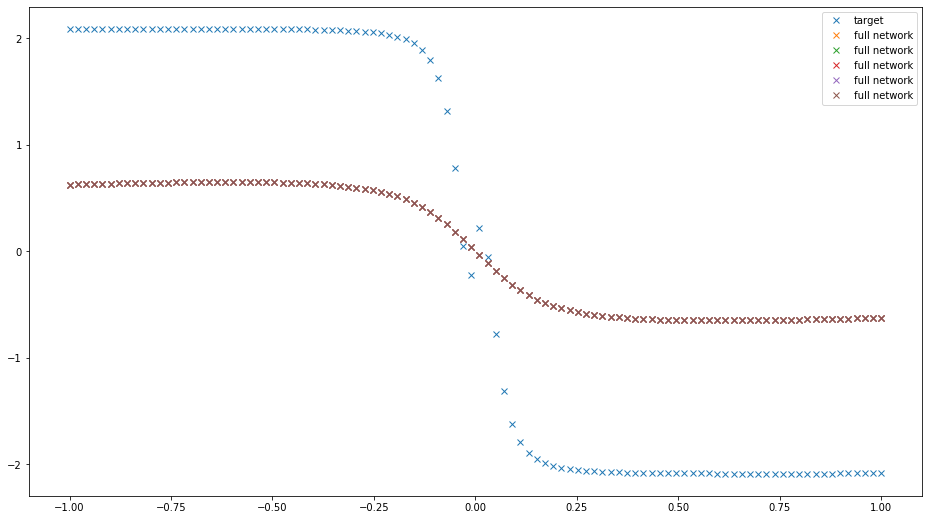

In [13]:
plt.plot(X.squeeze(), yhat.squeeze(),'x',label='target')
plt.plot(X.squeeze(), yhat_full.squeeze(),'x',label='full network')
plt.legend()

In [14]:
yhat.shape

(100, 1, 1)

# Define Attentional TS (ToDo: move to package)

In [15]:
class IndependentAttentionTS():
    def __init__(self,attention_size):
        self.ts_list = [GaussianBandit(num_options=2) for arm in range(attention_size)]
        
    def get_attention(self):
        
        attention = [ts.choose_arm() for ts in self.ts_list]
        return np.atleast_2d(attention)
    
    def update(self, attention, reward):
        for i, arm in enumerate(attention):
            ts = self.ts_list[i]
            
            ts.update(arm, reward)
            
            
class DependentAttentionTS():
    def __init__(self, attention_size, num_arms):
        self.arms = list(set([tuple(np.random.choice([0,1],p=[0.5,0.5],size = attention_size)) for i in range(num_arms)]))
        self.arms = np.array([np.array(arm) for arm in self.arms])
        self.ts = GaussianBandit(len(self.arms))
        
        
    def get_arm(self):
        return self.ts.choose_arm()
        
        
    def get_attention(self, arm):
        return self.arms[arm]
    
    def update(self, arm, reward):
        self.ts.update(arm,reward)
        
        

In [16]:
dts = DependentAttentionTS(num_units, 30)
dts.arms, len(dts.arms), dts.ts.num_options

(array([[1, 0, 1, 1],
        [1, 1, 0, 1],
        [1, 0, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 0, 0],
        [0, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 1, 1, 1],
        [1, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 1, 1, 0],
        [0, 0, 1, 1],
        [0, 1, 0, 1]]),
 14,
 14)

## check if the hidden attention is in the sampler's arms

In [17]:
[dts.get_arm() for i in range(10)], attention in dts.arms, attention

([7, 6, 7, 13, 6, 3, 11, 6, 5, 2], True, array([1, 1, 1, 0]))

# Train the sampler

In [18]:
epochs = 1
from sklearn.utils import shuffle

errors = []

for i in range(epochs):
    
    X_shuffle, y_shuffle = shuffle(X.T,yhat)
    for x, y in zip(X_shuffle, y_shuffle):


        x = np.atleast_2d(x)
        arm = dts.get_arm()
        attention_new = dts.get_attention(arm)


        prediction = model.forward(x, attention_new)


        error = - np.sqrt( (y - prediction)**2)
        errors.append(error)

        dts.update(arm, error[0][0])


# Test the samplers' convergence choices

Show the most likely arms, and check it it's close to hidden attention

In [19]:
a = [dts.get_attention(dts.get_arm()) for i in range(100)]
np.mean(a,0) > 0.5, np.mean(a,0), attention

(array([ True,  True,  True, False]),
 array([1.  , 0.96, 0.96, 0.  ]),
 array([1, 1, 1, 0]))

Error Decreases:

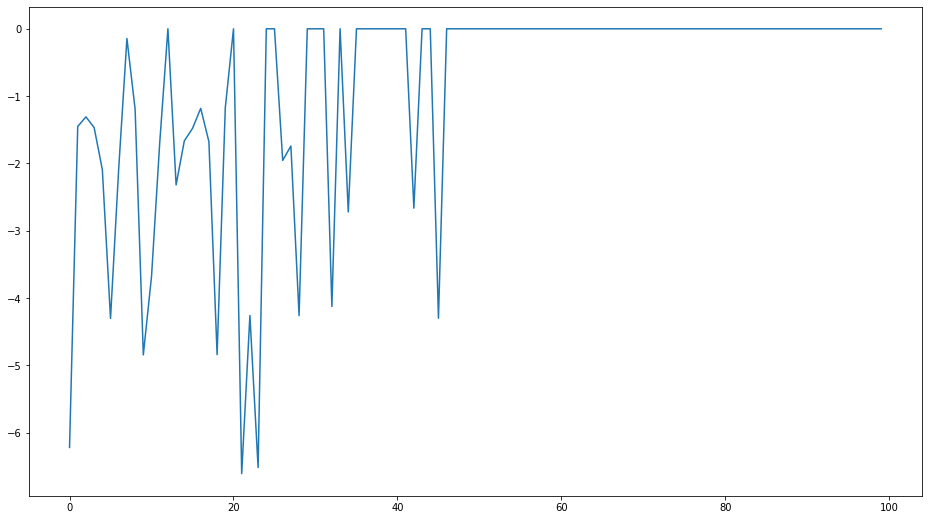

In [20]:
plt.plot(np.array(errors).squeeze())

# Plot the recovered function predictions

In [21]:
pred_samples = 10

ensemble_preds = []
for i in range(pred_samples):
    
    predictions = []

    for x, y in zip(X.T, yhat):
    

        x = np.atleast_2d(x)
        arm = dts.get_arm()
        attention_new = dts.get_attention(arm)


        predictions += [model.forward(x, attention_new).squeeze()]



    ensemble_preds.append(np.array(predictions))


In [22]:
model.forward(x,attention).shape, attention

((1, 1), array([1, 1, 1, 0]))

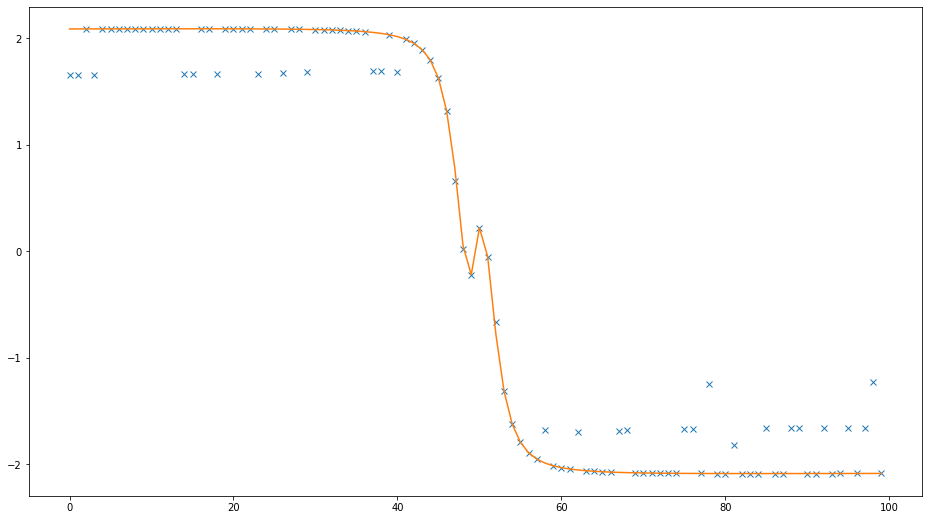

In [23]:
plt.plot(np.mean(ensemble_preds,0),'x')

plt.plot(yhat.squeeze())

# Plot the Params

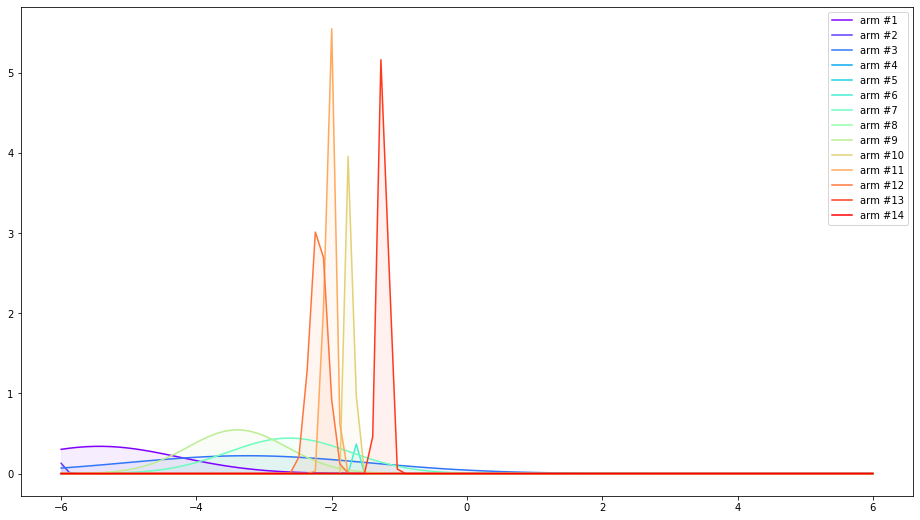

In [24]:
dts.ts.plot_params()

In [25]:
# !nbdev_build_docs

In [26]:
attention

array([1, 1, 1, 0])

# Contextual Case

In [27]:
model2 = NeuralNetwork(loss='mean-square-error',randomMultiplier=1)

model2.addLayer(inputDimension=2, units=100, activation='tanh')#,layer_type = DropoutLayer)
model2.addLayer( units=num_units, activation='tanh')
model2.addLayer( units=5, activation='tanh',layer_type = AttentionDropoutLayer)
model2.addLayer( units=num_units, activation='tanh')
model2.addLayer( units=1, activation='')#,layer_type = AttentionDropoutLayer)
model2


[
  1 -> Dense layer (nx=2, nh=100, activation=tanh)
  2 -> Dense layer (nx=100, nh=4, activation=tanh)
  3 -> Attention Dropout layer (nx=4, nh=5, activation=tanh)
  4 -> Dense layer (nx=5, nh=4, activation=tanh)
  5 -> Dense layer (nx=4, nh=1, activation=none)
]

In [28]:
A2 = np.atleast_2d([1,1]).T
A2.shape

(2, 1)

In [29]:
model2.forward(A2,attention=attention).shape

(1, 1)

In [30]:
X1 = np.atleast_2d(np.linspace(-10,10,100))
X2 = np.random.choice([0,1],size=X1.shape)


#attention = np.ones(model.layers[2].weights.shape)

dropout_percent = 0.5

attention1 = np.random.binomial([np.ones((model.layers[2].weights.shape[1]))],1-dropout_percent)[0]#.shape
attention2 = np.random.binomial([np.ones((model.layers[2].weights.shape[1]))],1-dropout_percent)[0]#.shape

full_attention = np.ones(model.layers[2].weights[1].shape)

In [31]:
X1.shape, X2.shape

((1, 100), (1, 100))

In [32]:
attention1, attention2

(array([0, 1, 1, 1]), array([0, 1, 0, 0]))

In [33]:
X = np.concatenate([X1,X2])
X.shape

(2, 100)

In [34]:
x = X[:,0]
x.shape

(2,)

In [35]:
model2.forward(np.atleast_2d(x).T,attention).shape

(1, 1)

In [36]:
yhat = []

for x in X.T:
    if x[1]:
        yhat += [model2.forward(np.atleast_2d(x).T, attention1)]        
    else:
        yhat += [model2.forward(np.atleast_2d(x).T, attention2)]


yhat = np.array(yhat)

In [37]:
yhat.shape

(100, 1, 1)

In [38]:
full_attention

array([1., 1., 1., 1.])

In [39]:

yhat_full = []

for x in X.T:
    yhat_full += [model2.forward(np.atleast_2d(x).T, full_attention)]

yhat_full = np.array(yhat_full)

In [40]:
yhat_full.shape

(100, 1, 1)

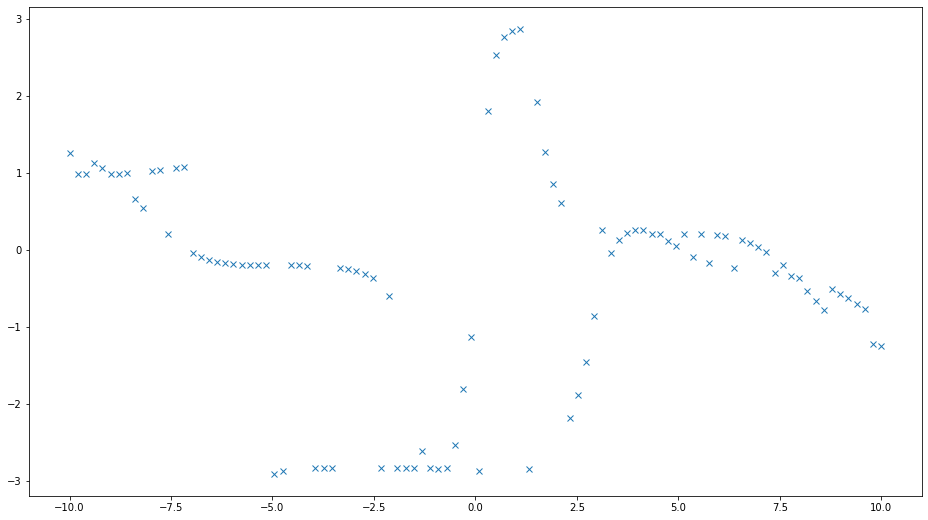

In [41]:
plt.plot(X[0].squeeze(), yhat_full.squeeze(),'x',label='full network')


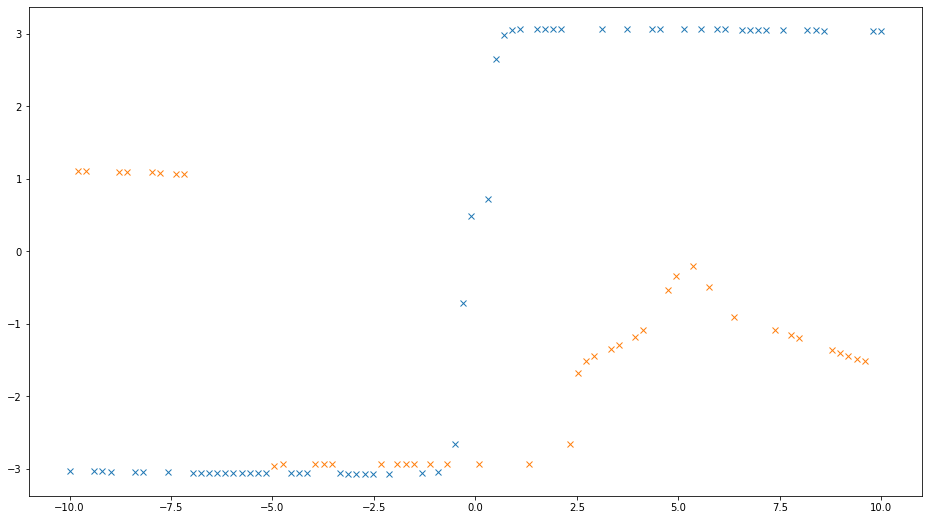

In [42]:
#plt.plot(X[0].squeeze(), yhat.squeeze(),'x',label='target')
plt.plot(X[0][X[1]==0].squeeze(), yhat[X[1]==0].squeeze(),'x',label='target')
plt.plot(X[0][X[1]==1].squeeze(), yhat[X[1]==1].squeeze(),'x',label='target')



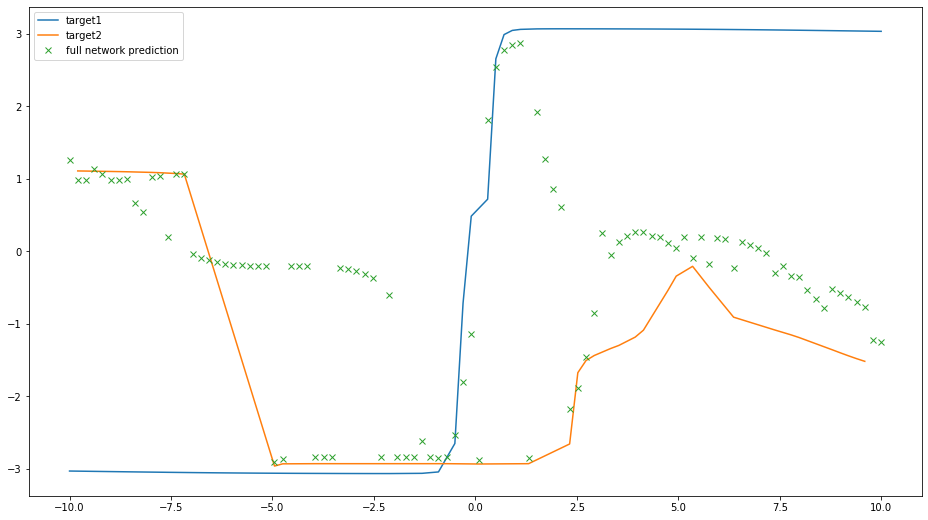

In [43]:
plt.plot(X[0][X[1]==0].squeeze(), yhat[X[1]==0].squeeze(),label='target1')
plt.plot(X[0][X[1]==1].squeeze(), yhat[X[1]==1].squeeze(),label='target2')

plt.plot(X[0].squeeze(), yhat_full.squeeze(),'x',label='full network prediction')
plt.legend()

(100, 1, 1)

In [44]:
from neuralThompsonTrainer.thompson_sampler import GaussianUniversalContextualSampler, BatchBayesLinReg
from neuralThompsonTrainer.neural_networks import NeuralNetworkRegressionEnsemble

In [45]:
gucs = GaussianUniversalContextualSampler(BatchBayesLinReg,num_arms=2, num_context = 1,model_params={'alpha':2, 'beta':1})
gucs = GaussianUniversalContextualSampler(NeuralNetworkRegressionEnsemble,num_arms=2, num_context = 1,model_params={})




In [46]:
class ContextualDependentAttentionTS():
    def __init__(self, attention_size, num_arms, num_context, model_params, model = None):
        self.arms = list(set([tuple(np.random.choice([0,1],p=[0.5,0.5],size = attention_size)) for i in range(num_arms)]))
        self.arms = np.array([np.array(arm) for arm in self.arms])

        self.model = model or BatchBayesLinReg
        self.ts = GaussianUniversalContextualSampler(self.model,num_arms=len(self.arms), num_context = num_context,model_params=model_params)

        
        
    def get_arm(self, context):
        return self.ts.choose_arm(context)
        
        
    def get_attention(self, arm):
        return self.arms[arm]
    
    def update(self, arm, context, reward):
        self.ts.update(arm, context, reward)

In [47]:
cdats = ContextualDependentAttentionTS(num_units, 100, 2, model_params={'num_units':10, 'activation':'tanh'}, model=NeuralNetworkRegressionEnsemble)

In [48]:
arm1_index = list(cdats.arms.tolist()).index(list(attention1))
arm2_index = list(cdats.arms.tolist()).index(list(attention2))

In [49]:
cdats.get_arm(A2)

2

In [50]:
#cdats.update(9, A2.T, 1)

In [51]:
cdats.get_attention(9)

array([1, 0, 0, 1])

In [52]:
attention2

array([0, 1, 0, 0])

In [53]:
#cdats = ContextualDependentAttentionTS(num_units, 30, 2, {'alpha':1, 'beta':4})

In [54]:
list(cdats.arms.tolist()).index(list(attention1))

5

In [55]:
epochs = 10
from sklearn.utils import shuffle

errors = []

for i in range(epochs):
    
    X_shuffle, y_shuffle = shuffle(X.T,yhat)

    for x, y in zip(X_shuffle, y_shuffle):

        x = np.atleast_2d(x)
        #print(x)

        arm = cdats.get_arm(x.T)
        attention_new = cdats.get_attention(arm)


        prediction = model2.forward(np.atleast_2d(x).T, attention_new)


        error = - np.sqrt( (y - prediction)**2)
        errors.append(error)

        cdats.update(arm,x.T, error[0][0])


In [56]:
model2.forward(np.atleast_2d(x).T, attention_new).shape

(1, 1)

In [57]:
x

array([[10.,  0.]])

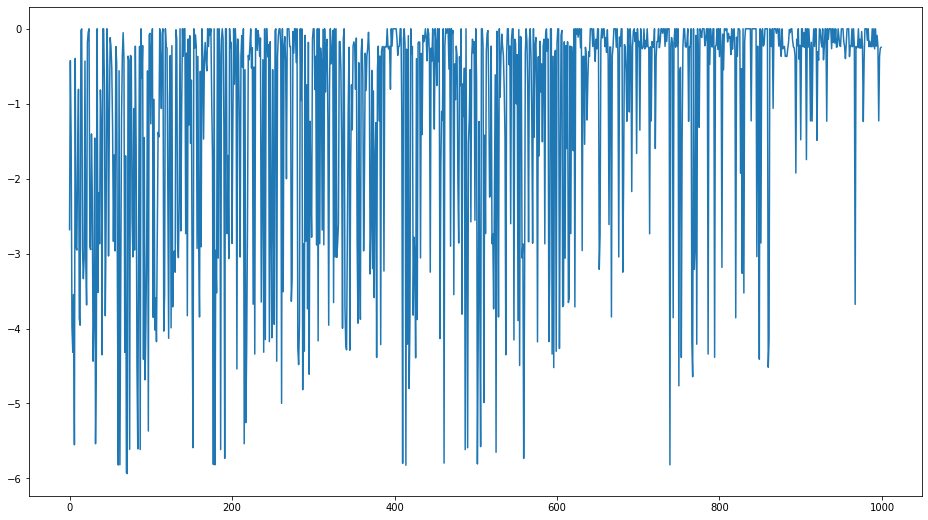

In [58]:
plt.plot(np.array(errors).squeeze())
#plt.plot(np.cumsum(np.array(errors).squeeze()))

In [59]:
arm1_data = np.array([[data,1] for data in np.linspace(-10,10,100) ])


In [60]:
arm2_data = np.array([[data,0] for data in np.linspace(-10,10,100) ])


In [61]:
chosen_arms1 = [ cdats.get_arm(np.atleast_2d(data).T) for data in arm1_data]
chosen_arms2 = [ cdats.get_arm(np.atleast_2d(data).T) for data in arm2_data]

In [62]:
import collections

In [63]:
counts1 =collections.Counter(chosen_arms1)
counts2 = collections.Counter(chosen_arms2)
#
#counts1, counts2, counts1[arm1_index],counts1[arm2_index],counts2[arm1_index],counts2[arm2_index]

In [64]:
counts1.most_common()[0][0], counts2.most_common()[0][0], arm1_index, arm2_index

(5, 12, 5, 11)

In [65]:
counts1, counts2

(Counter({3: 4, 7: 37, 5: 49, 14: 3, 6: 5, 0: 1, 12: 1}),
 Counter({3: 21, 7: 22, 11: 13, 12: 43, 5: 1}))

In [66]:
len(counts1), len(counts2)

(7, 5)

In [67]:
pred_samples = 10

ensemble_preds = []
for i in range(pred_samples):
    
    predictions = []

    for x in X.T:
    

        x = np.atleast_2d(x)
        arm = cdats.get_arm(x.T)
        attention_new = cdats.get_attention(arm)


        predictions += [model2.forward(np.atleast_2d(x).T, attention_new).squeeze()]



    ensemble_preds.append(np.array(predictions))

In [68]:
x, arm1_data[0], X[:,0]

(array([[10.,  0.]]), array([-10.,   1.]), array([-10.,   0.]))

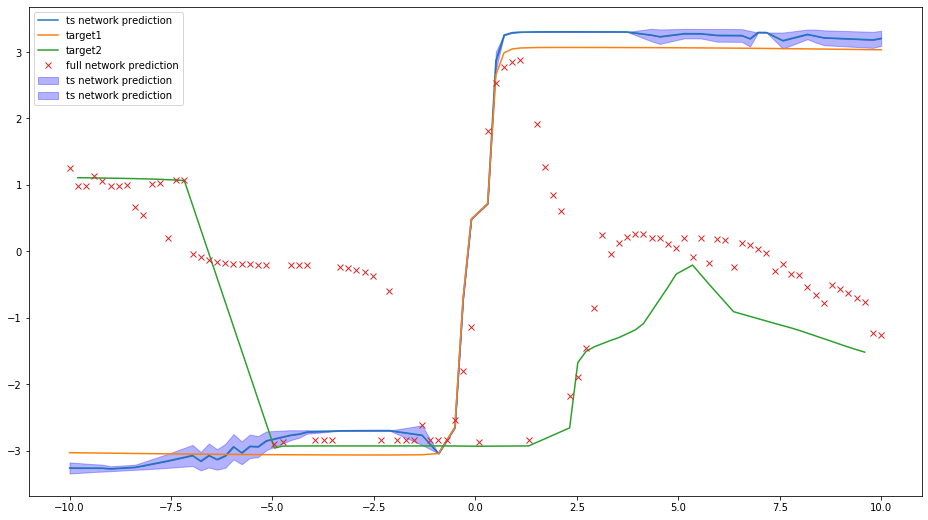

In [69]:
plt.plot(X[0][X[1]==0].squeeze(), np.mean(ensemble_preds,0)[X[1]==0],label='ts network prediction')
plt.fill_between(X[0][X[1]==0].squeeze(), np.mean(ensemble_preds,0)[X[1]==0], np.mean(ensemble_preds,0)[X[1]==0] + np.std(ensemble_preds,0)[X[1]==0],label='ts network prediction',alpha=0.3,color='blue')
plt.fill_between(X[0][X[1]==0].squeeze(), np.mean(ensemble_preds,0)[X[1]==0], np.mean(ensemble_preds,0)[X[1]==0] - np.std(ensemble_preds,0)[X[1]==0],label='ts network prediction',alpha=0.3,color='blue')

plt.plot(X[0][X[1]==0].squeeze(), yhat[X[1]==0].squeeze(),label='target1')
plt.plot(X[0][X[1]==1].squeeze(), yhat[X[1]==1].squeeze(),label='target2')


plt.plot(X[0].squeeze(), yhat_full.squeeze(),'x',label='full network prediction')
plt.legend()

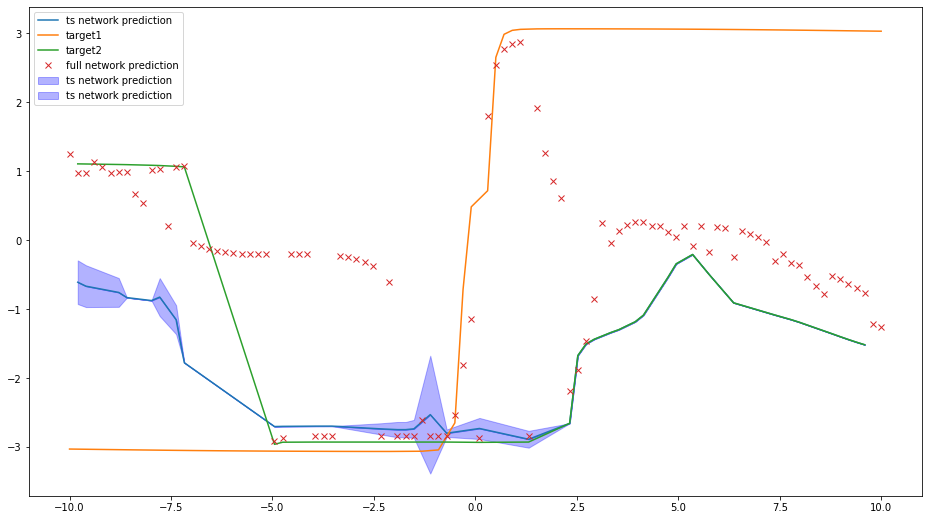

In [70]:


plt.plot(X[0][X[1]==1].squeeze(), np.mean(ensemble_preds,0)[X[1]==1],label='ts network prediction')
plt.fill_between(X[0][X[1]==1].squeeze(), np.mean(ensemble_preds,0)[X[1]==1], np.mean(ensemble_preds,0)[X[1]==1] + np.std(ensemble_preds,0)[X[1]==1],label='ts network prediction',alpha=0.3,color='blue')
plt.fill_between(X[0][X[1]==1].squeeze(), np.mean(ensemble_preds,0)[X[1]==1], np.mean(ensemble_preds,0)[X[1]==1] - np.std(ensemble_preds,0)[X[1]==1],label='ts network prediction',alpha=0.3,color='blue')

plt.plot(X[0][X[1]==0].squeeze(), yhat[X[1]==0].squeeze(),label='target1')
plt.plot(X[0][X[1]==1].squeeze(), yhat[X[1]==1].squeeze(),label='target2')


plt.plot(X[0].squeeze(), yhat_full.squeeze(),'x',label='full network prediction')
plt.legend()